<a href="https://colab.research.google.com/github/hibatallahk/TimeSeriesDriversPredictionsML/blob/main/TimeSeriesTaxiPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Taxi orders prediction using Machine Learning
# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# Goal of the project

- The main goal of this project is to build a model for the amount of taxi orders prediction.

# Table of Content

<div> 
    <ol>
      <li><a href="#1"> Data downloading</a></li>
      <li><a href="#2"> Data preparation</a></li>
      <li><a href="#3">Model analysis</a></li> 
      <li><a href="#4">Model training</a></li>
      <li><a href="#5">Model testing</a></li>
      <li><a href="#6">Overall Conclusion</a></li>
    </ol> 
</div>

# <a id="1"> Data Loading

In [1]:
#Import all libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns   #visualization

sns.set(style="ticks", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

import xgboost as xgb 
from lightgbm import LGBMRegressor
RMSE_THRESHOLD=48
import sys
print (sys.version)

import warnings 
warnings.filterwarnings('ignore')
print('Libraries imported succesfully')

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Libraries imported succesfully


In [2]:
 data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [3]:
# function to determine if columns in file have null values
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")
        
# function to display general information about the dataset
def get_info(df):
    """
    This function uses the head(), info(), describe(), shape() and duplicated() 
    methods to display the general information about the dataset.
    """
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head())
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print('-'*100)
    display(df.describe(include='object'))
    print()
    print('Columns with nulls:')
    display(get_percent_of_na(df, 4))  # check this out
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.\n'.format(df.duplicated().sum()) + "\033[0m")
    print()

In [4]:
# study the general information about the dataset 
print('General information about the dataframe')
get_info(data)

General information about the dataframe
----------------------------------------------------------------------------------------------------
Head:



,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

----------------------------------------------------------------------------------------------------
Describe:



,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


----------------------------------------------------------------------------------------------------


,datetime
count,26496
unique,26496
top,2018-05-27 22:40:00
freq,1



Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(26496, 2)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.




**Conclusion**
- Our data contains 26496 rows & 2 columns.
- `datetime` is an object column and must be changed to datetime64
- the dataset doesn't contain any missing or duplicated values.

# <a id="2"> Data Preparation

In [5]:
data['datetime'] = data['datetime'].astype('datetime64')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [7]:
data.set_index('datetime', inplace=True)

- With `is_monotonic` attribute, if the order is chronological, the attribute will return True; if not, False

In [8]:

data.index.is_monotonic

True

In [9]:
data.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


- Plot the time series graph.

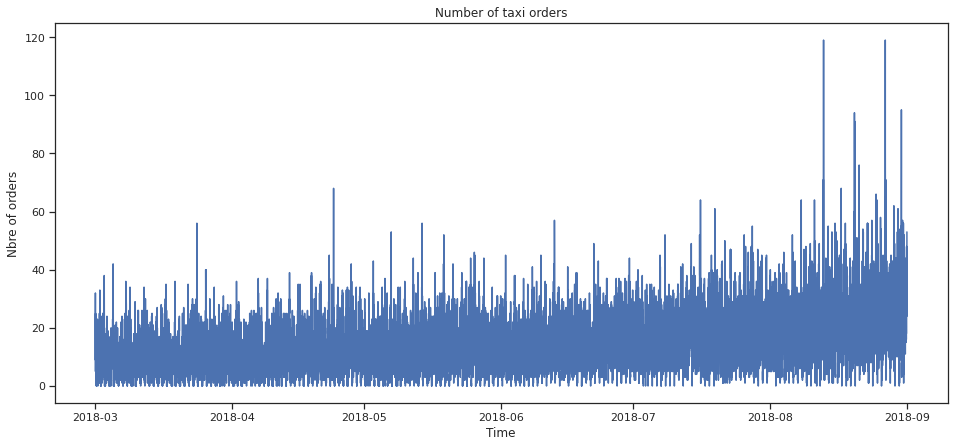

In [11]:
plt.figure(figsize=(16,7))
plt.title('Number of taxi orders')
plt.xlabel('Time')
plt.ylabel('Nbre of orders')
plt.plot(data['num_orders']);


**Conclusion**
- We've changed the `datetime` type from object to datetime64
- we've set `datetime` as the dataframe index
- and checked whether the order of the data is chronological or not with the `is_monotonic` attribute
- and finaly visualzed the time series data

# <a id="3"> Model Analysis

## Resampling

- The time series data is already grouped for each 10 minutes
- we are ressampling the data by 1 hour & calculate the sum of the grouped values for each hour

In [12]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


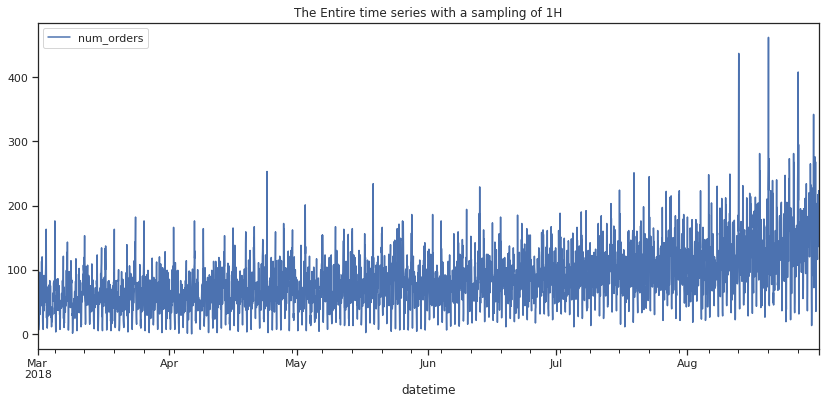

In [13]:
data.plot(figsize=(14,6),title='The Entire time series with a sampling of 1H');

- we see a positive trend from March to the end of September.
- Here we can see that the timeseries are not stationary since its values are growing.


- Select the 2 weeks time period for data ressampling.

In [14]:
week_sampling = data['2018-03-01':'2018-03-14']
day_simpling = data['2018-03-01']

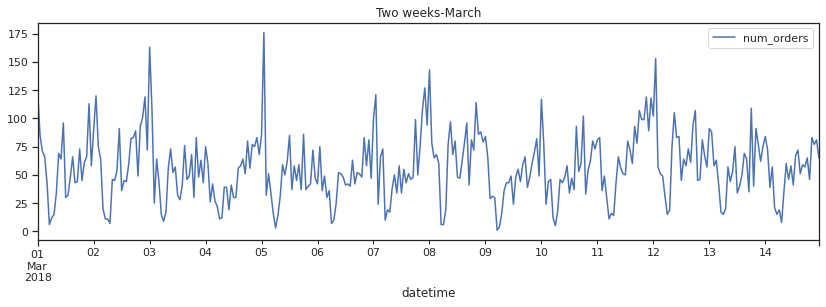

In [15]:
week_sampling.plot(figsize=(14,4),title='Two weeks-March');

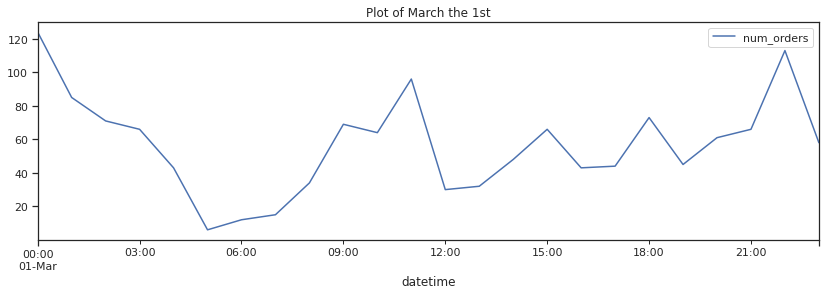

In [16]:
day_simpling.plot(figsize=(14,4),title='Plot of March the 1st');

- It's hard to make analysis with those fluctuations, let's remove them.

## Rolling Mean

To reduce the fluctuations in our time series, we are using the rolling mean helping for data smoothing.
- The method involves finding the values least susceptible to fluctuations, that is, the arithmetic mean.

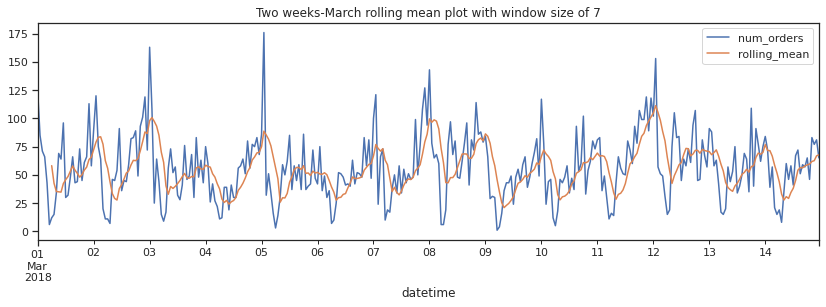

In [17]:
#using a window size of 7
week_sampling['rolling_mean'] = week_sampling.rolling(7).mean() 
week_sampling.plot(figsize=(14,4),title='Two weeks-March rolling mean plot with window size of 7');

- Find the rolling standard deviation (rolling std)

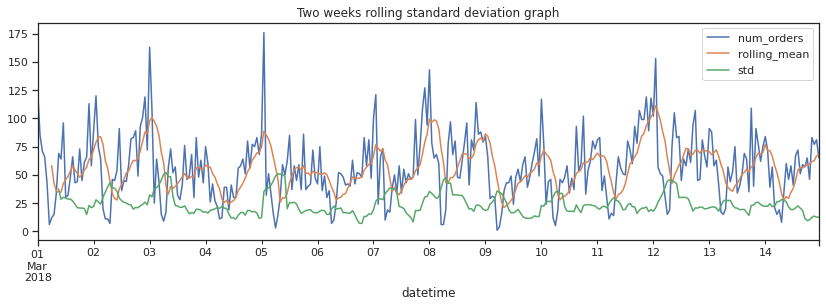

In [18]:
week_sampling['std'] = week_sampling['num_orders'].rolling(10).std() 
week_sampling.plot(figsize=(14,4),title='Two weeks rolling standard deviation graph');

- It seems that the data still has consistent fluctuations

## Daily / Weekend's taxi orders

In [19]:
data1hour_day = week_sampling['2018-03-01']
data2hour_day =  week_sampling['2018-03-02']
data1hour_saturday = week_sampling[week_sampling.index.weekday==5].head(24)
data2hour_saturday = week_sampling[week_sampling.index.weekday==5].tail(24)
data1hour_sunday = week_sampling['2018-03-04']
data2hour_sunday = week_sampling['2018-03-11']

## Visualizing

**2 consecutive Days**


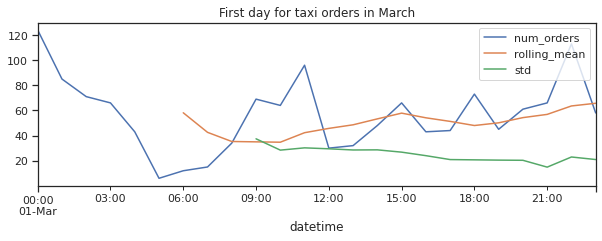

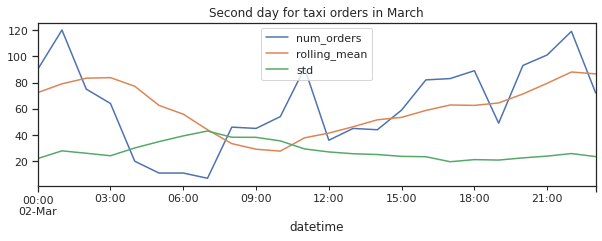

In [20]:
data1hour_day.plot(figsize=(10,3),title='First day for taxi orders in March')
data2hour_day.plot(figsize=(10,3),title='Second day for taxi orders in March');

**2 consecutive Saturdays**


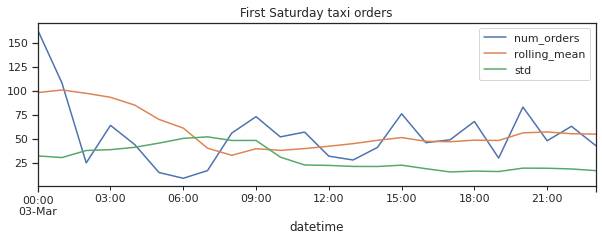

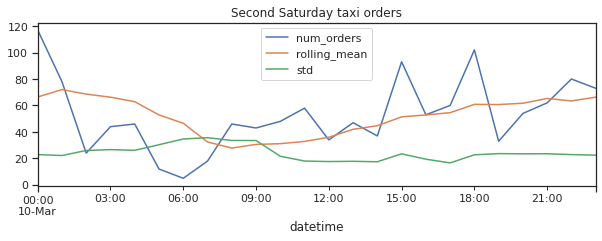

In [21]:
data1hour_saturday.plot(figsize=(10,3),title='First Saturday taxi orders')
data2hour_saturday.plot(figsize=(10,3),title='Second Saturday taxi orders');

**2 consecutive Sundays**

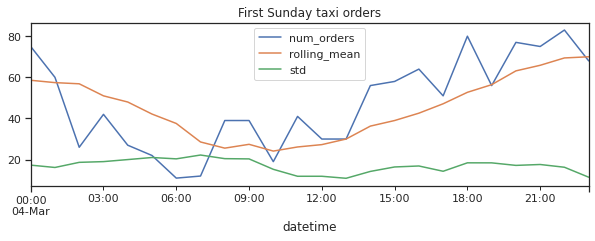

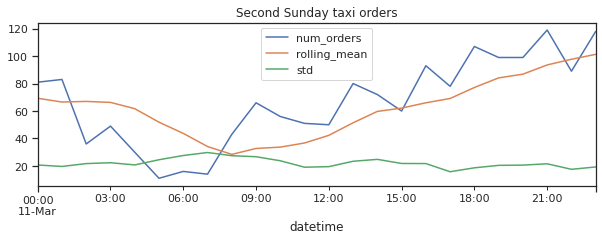

In [22]:
data1hour_sunday.plot(figsize=(10,3),title='First Sunday taxi orders')
data2hour_sunday.plot(figsize=(10,3),title='Second Sunday taxi orders');

**Conclusion**

From those plots we can say:
- No matter what day it is, it is clear that the orders are remarkably fewer aroud 6/7am. The curve starts to increase slowly from 9/10am. And increase higher from around 6pm.
- Possibly due to the fact that many are going to work at 9am and coming back at 6pm, the increase after 9pm is probably due to the parties and dinners etc. 
- Let's check trends and seasonality to dig more into this.

## Trends / Seasonality

- A *Trend* is a smooth change of the mean value of the series without repeating patterns. For example, annual increase in taxi rides.
- *Seasonality* means cyclically repeating patterns in a time series. For instance, the growth of increase in taxi rides on weekdays.
- We Decompose the time series data into Trend /Seasonal /Residual components.

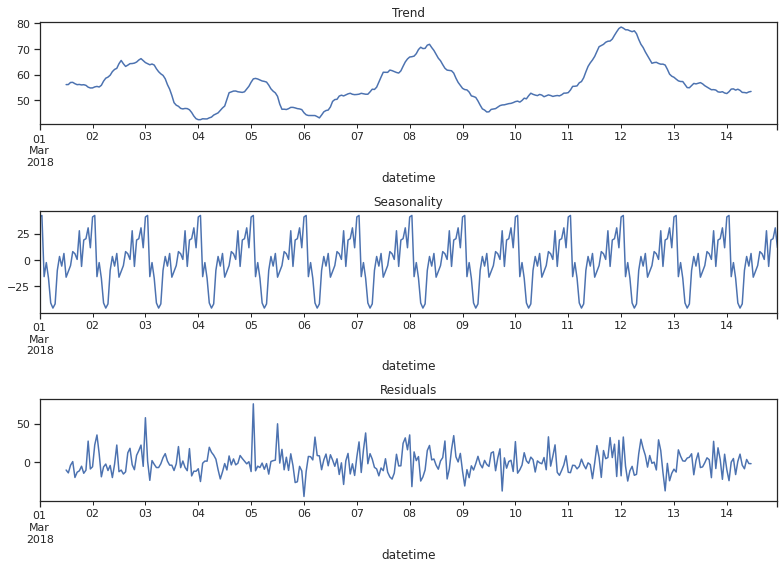

In [23]:
decomposed = seasonal_decompose(week_sampling['num_orders'].dropna())

plt.figure(figsize=(11, 8))
# plt.subplot(311) says 3 rows, 1 column, first image. 
plt.subplot(311)

# To display the graph correctly, specify its axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout() # this helps fit subplots into the area 

## Seasonality / 2 week-days and a week-end

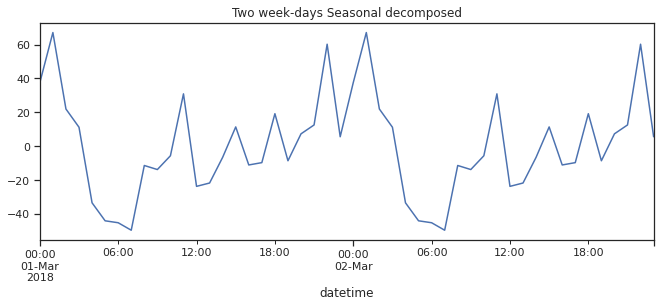

In [24]:
tmp = week_sampling['2018-03-01':'2018-03-02']
decomposed = seasonal_decompose(tmp['num_orders'].dropna())
decomposed.seasonal.plot(figsize=(11,4), title='Two week-days Seasonal decomposed');

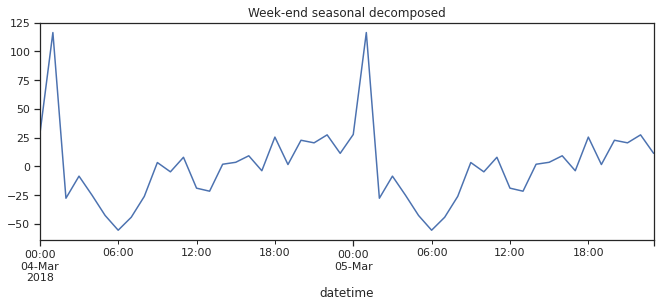

In [25]:
tmp = week_sampling['2018-03-04':'2018-03-05']
decomposed = seasonal_decompose(tmp['num_orders'].dropna())
decomposed.seasonal.plot(figsize=(11,4),title='Week-end seasonal decomposed');

**Conclusion**

- Whether it is for week-days or week-end:
  - the seasonality visualization looks similar.
  - taxi rides start decreasing remarkably after midnight and increasing from 6am.
  - there is 2 peaks: 
    - around noon
    - before midnight.


## Checking whether the time series are stationary or not

- Stationary series can help forecast data. 
- We will use Time Series Difference by shifting the data, computing the difference, and visualizing



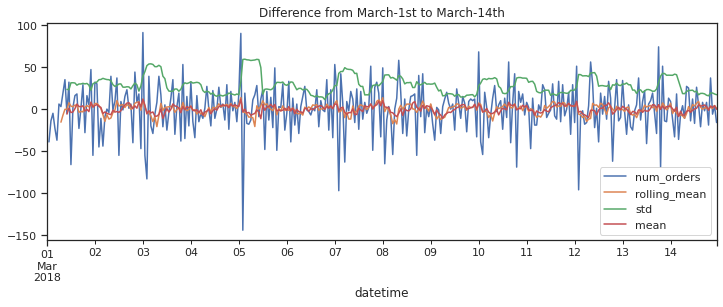

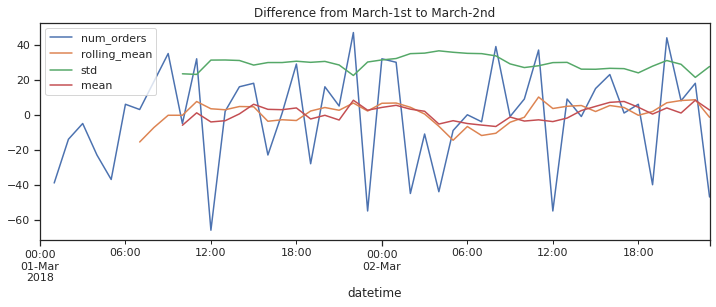

In [26]:
data_diff_w = week_sampling - week_sampling.shift() # < write code here >
data_diff_w['mean'] = data_diff_w['num_orders'].rolling(10).mean()
data_diff_w['std'] = data_diff_w['num_orders'].rolling(10).std()
data_diff_d = data_diff_w['2018-03-01':'2018-03-02']
data_diff_w.plot(figsize=(12,4),title = 'Difference from March-1st to March-14th')
data_diff_d.plot(figsize=(12,4),title = 'Difference from March-1st to March-2nd');

- The series seems stationary, since the the mean and standard deviation are not remarkebly changing. 
- The data can be forecasted now.

# <a id="4"> Model Training

## Forecast Accuracy

- The point of time series forecasting is developing a model which predicts the future values of a time series based on previous data.
- We will evaluate the model using the previous value in the series, predict the hourly taxi orders and find the RMSE value.

In [27]:
data.shape

(4416, 1)

In [28]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [29]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
print("Median hourly taxi orders:", test['num_orders'].median())
num = train.iloc[len(train)-1]['num_orders']
pred_previous = test.shift(fill_value=num)
# root-mean-square error
rmse = np.sqrt(mean_squared_error(test['num_orders'],pred_previous))
print("rmse",rmse)

Median hourly taxi orders: 135.0
rmse 58.856486242815066


- with this forecast, the model is sanity checked which serves as a useful benchmark. 
- let's move to the training to get better predictions/better rmse score.

## Creating Features

- We will create features for a one-step forecast horizon.
- Let's start by adding Lag values, and rolling_mean to data

In [30]:
#Create a dataframe to dataframe name, Model name and model results
column_names = ['Model','Lag','RollingWindowSize','RMSE_validation','HyperParams']
##Intitialize lists data. 
df_results = pd.DataFrame(columns = column_names)
display(df_results)

,Model,Lag,RollingWindowSize,RMSE_validation,HyperParams


In [31]:
#Define a function for RMSE scoring
def rmse_scorer(target: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mean_squared_error(target, predicted))
      
rmse_scoring = make_scorer(rmse_scorer)

In [32]:
def updateResults(model_name,lag,RollingWindowSize,rmseValid,HyperParams,df_results):

    resultRowStr= [model_name,lag,RollingWindowSize,rmseValid,HyperParams]
    rows = [pd.Series(resultRowStr, index=df_results.columns)]
    df_results=df_results.append(rows,ignore_index=True)#append rows
    
    return(df_results)#check the rows 


In [33]:
def evaluateModel(model,features_train,target_train,features_trial,target_trial):
    model.fit(features_train, target_train)
    predicted_trial = model.predict(features_trial)
    rmseTrial = rmse_scorer(target_trial, predicted_trial) 
    return(rmseTrial)

In [34]:
evaluationModels = [
                    LinearRegression(),
                    RandomForestRegressor(random_state=12345),
                    XGBRegressor(objective='reg:squarederror',random_state=12345),
                    LGBMRegressor(random_state=12345)
                    ]

evaluationModelNames = ['LinearRegression','RandomForestRegressor','XGBRegressor','LightGBMRegressor']
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

def make_lags(data, max_lag, rolling_mean_size):
    data1 = data.copy()   
    for lag in range(1, max_lag + 1):
        data1['lag_{}'.format(lag)] = data1['num_orders'].shift(lag)

    data1['rolling_mean'] = data1['num_orders'].shift().rolling(rolling_mean_size).mean()
    data1.dropna(inplace=True)
    return data1

def make_features(lag,rollingWindowSize):
    data1 = arrLags[rollingWindowSize][lag]
    features=data1.drop('num_orders',axis=1)
    target = data1['num_orders']
    return features,target

In [35]:
#make a 2-dimensional array of the dataframes with different values of rollingWindowSize and lag.
# This is done to avoid repeating the make of dataframes for validation and test sets.
rows, cols = (5, 8) 
arrLags = [[data for i in range(cols)] for j in range(rows)] 
for rollingWindowSize in range(1,5):
    for lag in range(1,8):
            arrLags[rollingWindowSize][lag] = make_lags(data,lag,rollingWindowSize)

## Model Evaluation

Evaluation for:

- LinearRegression
- RandomForestRegressor
- XGBRegressor
- LGBMRegressor

In [36]:
for rollingWindowSize in range(1,5):
    for lag in range(1,8):
            features,target = make_features(lag,rollingWindowSize)
            
            features_train, features_validtest, target_train, target_validtest = train_test_split(
                    features, target, test_size=0.2, shuffle=False,random_state=12345)

            features_valid, features_test, target_valid, target_test = train_test_split(
                    features_validtest, target_validtest, test_size=0.5, shuffle=False,random_state=12345)
            
            i=0
            for model in evaluationModels:
                modelName = evaluationModelNames[i]
                hyperParam=''
                rmseValid = evaluateModel(model,features_train, target_train,features_valid,target_valid)
                df_results = updateResults(modelName,lag,rollingWindowSize,rmseValid,"",df_results)
                i=i+1
                
    totsize = len(data)

print('***********')
print('training set  : {0:.0%}'.format(len(features_train) /totsize),features_train.shape, ', training target   :',target_train.shape)
print('valid set: {0:.0%}'.format(len(features_valid)/totsize),features_valid.shape,', valid target :',target_valid.shape)
print('test set: {0:.0%}'.format(len(features_test)/totsize),features_test.shape,', test target :',target_test.shape)
print('***********')
display(df_results)
print()

***********
training set  : 80% (3527, 13) , training target   : (3527,)
valid set: 10% (441, 13) , valid target : (441,)
test set: 10% (441, 13) , test target : (441,)
***********


,Model,Lag,RollingWindowSize,RMSE_validation,HyperParams
0,LinearRegression,1,1,40.965781,
1,RandomForestRegressor,1,1,34.809238,
2,XGBRegressor,1,1,34.355894,
3,LightGBMRegressor,1,1,34.193484,
4,LinearRegression,2,1,41.120809,
...,...,...,...,...,...
107,LightGBMRegressor,6,4,32.690222,
108,LinearRegression,7,4,40.532138,
109,RandomForestRegressor,7,4,32.667550,
110,XGBRegressor,7,4,32.695977,


## Feature Validation

top 4 Best **RMSEs**

In [37]:
result_1 = df_results.sort_values('RMSE_validation',ascending=True).head(4)
display(result_1)

,Model,Lag,RollingWindowSize,RMSE_validation,HyperParams
83,LightGBMRegressor,7,3,31.975075,
111,LightGBMRegressor,7,4,32.028683,
82,XGBRegressor,7,3,32.115494,
27,LightGBMRegressor,7,1,32.289539,


**Conclusion**

we can see from the results that:
- LightGBMRegressor has the best RMSE
- XGBRegressor is also ammongst the best.

## Feature Validation

- We will list here models with best RMSEs

In [38]:
result_2 = df_results.sort_values('RMSE_validation',ascending=True).groupby('Model').head(1)
result_3 = result_1.append(result_2).drop_duplicates(keep='first')
display(result_3)

,Model,Lag,RollingWindowSize,RMSE_validation,HyperParams
83,LightGBMRegressor,7,3,31.975075,
111,LightGBMRegressor,7,4,32.028683,
82,XGBRegressor,7,3,32.115494,
27,LightGBMRegressor,7,1,32.289539,
25,RandomForestRegressor,7,1,32.611417,
108,LinearRegression,7,4,40.532138,


**Conclusion**

From the evaluation of the 4 regression models, we conclude that:
- Three regression models resulted in RMSE between 31 and 32.xx. 
- The lag and RollingWindowSize are listed for each model.
- LR model had a higher RMSE on validation set.
- RMSE on validation set is lower than its required threshold (48).



## CROSS-VALIDATION

 Let's identify the best hyper-parameters for the following models to get better RMSE scores:

- LGBMRegressor
- XGBRegressor
- RandomForestRegressor

### LightGBMRegressor / GridSearchCV

In [39]:
# Required since Timeseries dataset
ts_cv = model_selection.TimeSeriesSplit(2) 

features,target = make_features(7,3)

features_train, features_validtest, target_train, target_validtest = train_test_split(
           features, target, test_size=0.2, shuffle=False,random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
           features_validtest, target_validtest, test_size=0.5, shuffle=False,random_state=12345)
            
param_grid =  {
              'num_leaves' : [31,35,40], 
              'learning_rate' : [0.5,0.1],
              'n_estimators' : [150],
              'eval_metric':['RMSE'],
              'random_state' : [12345],
               'n_jobs':[-1],
              }

LGBM_model = model_selection.GridSearchCV(estimator=LGBMRegressor(), param_grid=param_grid, cv=ts_cv)
LGBM_model.fit(features_train, target_train, verbose=0)

#model params
print("Best Params:")
best_params=LGBM_model.best_params_
print(best_params, "\n", "-" * 100)

##training params
LGBMmodel = LGBM_model.best_estimator_   #(**best_params)
rmseValid   = evaluateModel(LGBMmodel,features_train, target_train,features_valid,target_valid)
print('rmseValid:',rmseValid)

# append to the list
evaluationModels.append(LGBMmodel)
evaluationModelNames.append('LightGBM with Crossvalidation')
df_results = updateResults('LightGBM with Crossvalidation',7,3,rmseValid,best_params,df_results)

Best Params:
{'eval_metric': 'RMSE', 'learning_rate': 0.1, 'n_estimators': 150, 'n_jobs': -1, 'num_leaves': 35, 'random_state': 12345} 
 ----------------------------------------------------------------------------------------------------
rmseValid: 32.65810700513643


### XGBRegressor / GridSearchCV

In [40]:
# best parameters for lag / Rolling_Mean for XGBRegressor
features,target = make_features(7,3)

features_train, features_validtest, target_train, target_validtest = train_test_split(
           features, target, test_size=0.2, shuffle=False,random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
           features_validtest, target_validtest, test_size=0.5, shuffle=False,random_state=12345)

param_grid =   {
                'objective':['reg:squarederror'],
                'colsample_bytree': [0.3,0.7],
                'learning_rate':[0.5,0.1],
                'max_depth': [3,5,7], 
                'min_child_weight': [4,6], 
                'n_estimators': [50],
                'n_jobs':[-1],
                'alpha': [5,10],
                'seed':[12345],
                'nfold':[3,5],
                'num_boost_round':[50],
                'early_stopping_rounds':[50],
                'metrics':['rmse'],
                'silent': [1], 
                'subsample': [0.5,0.7]
                }

XGB_model = GridSearchCV(estimator=XGBRegressor(), param_grid =  param_grid,  cv=ts_cv )
XGB_model.fit(features_train, target_train, verbose=0)

# Print model params
print("Best Params:")
best_params=XGB_model.best_params_
print(best_params, "\n", "-" * 80)

##Specify the training parameters 
XGB_model = XGB_model.best_estimator_   
rmseValid   = evaluateModel(XGB_model,features_train, target_train,features_valid,target_valid)
print('rmseValid:',rmseValid)
# Append to the list
evaluationModels.append(XGB_model)
evaluationModelNames.append('XGBRegressor with Crossvalidation')
df_results = updateResults('XGBRegressor with Crossvalidation',7,3,rmseValid,best_params,df_results)

Best Params:
{'alpha': 5, 'colsample_bytree': 0.7, 'early_stopping_rounds': 50, 'learning_rate': 0.1, 'max_depth': 5, 'metrics': 'rmse', 'min_child_weight': 6, 'n_estimators': 50, 'n_jobs': -1, 'nfold': 3, 'num_boost_round': 50, 'objective': 'reg:squarederror', 'seed': 12345, 'silent': 1, 'subsample': 0.7} 
 --------------------------------------------------------------------------------
rmseValid: 33.213323197657544


### RF Regressor / GridSearchCV 

In [41]:
# best parameters for lag and RollingWindow_size for RandomForestRegressor

features,target = make_features(7,1)

features_train, features_validtest, target_train, target_validtest = train_test_split(
           features, target, test_size=0.2, shuffle=False,random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
           features_validtest, target_validtest, test_size=0.5, shuffle=False,random_state=12345)

param_grid=  {
            'n_estimators': [50],
            'criterion':['mse'],
            'n_jobs':[-1],
            'min_samples_leaf': [1,2,4],
            'min_samples_split': [2],
            'random_state':[12345]
        }

RFR_model = GridSearchCV(estimator=RandomForestRegressor(), param_grid =  param_grid,  cv=ts_cv)
RFR_model.fit(features_train, target_train)

#model params
print("Best Params:")
best_params=RFR_model.best_params_
print(best_params, "\n", "-" * 100)

#the training parameters 
RFR_model = RFR_model.best_estimator_  #RF_Regressor(best_params)
rmseValid   = evaluateModel(RFR_model,features_train, target_train,features_valid,target_valid)
print('rmse:',rmseValid)
# append to the list
evaluationModels.append(RFR_model)
evaluationModelNames.append('RandomForestRegressor with Crossvalidation')
df_results = updateResults('RandomForestRegressor with Crossvalidation',7,1,rmseValid,best_params,df_results)

Best Params:
{'criterion': 'mse', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 12345} 
 ----------------------------------------------------------------------------------------------------
rmse: 32.711369080492204


In [42]:
df_resultsFinal = result_3.append(df_results.tail(3)).sort_values(by='RMSE_validation')

In [43]:
display(df_resultsFinal)

,Model,Lag,RollingWindowSize,RMSE_validation,HyperParams
83,LightGBMRegressor,7,3,31.975075,
111,LightGBMRegressor,7,4,32.028683,
82,XGBRegressor,7,3,32.115494,
27,LightGBMRegressor,7,1,32.289539,
25,RandomForestRegressor,7,1,32.611417,
112,LightGBM with Crossvalidation,7,3,32.658107,"{'eval_metric': 'RMSE', 'learning_rate': 0.1, ..."
114,RandomForestRegressor with Crossvalidation,7,1,32.711369,"{'criterion': 'mse', 'min_samples_leaf': 1, 'm..."
113,XGBRegressor with Crossvalidation,7,3,33.213323,"{'alpha': 5, 'colsample_bytree': 0.7, 'early_s..."
108,LinearRegression,7,4,40.532138,


**Conclusion**

We have seen:
- LightGBMRegressor, XGBRegressor and RandomForestRegressor have validation RMSEs between 31 and 33
- Results of cross-validation along with the Hyperparameters.

Let's proceed with the evaluation on the test set.

# <a id="5"> Model Testing

## Test Models on the Test set

In this section we will:

- Use the results from the validation

- choose best parameters (Lag and Rolling Window Size) for each model.

- test sets using the new Lag and Rolling_Mean Window size.

- create features and test set
- re-tune the model on the features, then use it on prediction for the test target.

- test models with the parameters for Lag and the RollingWindow, for cross-validation models, and also add Hyperparams for evaluation.

In [44]:
df_resultsFinal.insert(4,'RMSE_test','')
df_resultsFinal.insert(5,'RMSE_Less_Than_48','')
df_resultsFinal['RMSE_test'] = np.nan
df_resultsFinal.reset_index(drop=True,inplace=True)
for i, row in df_resultsFinal.iterrows():
  modelName = row.Model

  features,target = make_features(row.Lag,row.RollingWindowSize)
           
  #90% training - 10% test      
  features_train, features_test, target_train, target_test = train_test_split(
          features, target, test_size=0.1, shuffle=False,random_state=12345)

  evalModel = evaluationModels[evaluationModelNames.index(modelName)]          
  rmseTest   = evaluateModel(evalModel,features_train, target_train,features_test,target_test)
  print(modelName,'rmse:',rmseTest,'Lag: ',row.Lag,'RollingMean:',row.RollingWindowSize)
  df_resultsFinal.at[i,'RMSE_test'] = rmseTest

print('*****************')
print()
print('training set  : {0:.0%}'.format(len(features_train) /totsize),features_train.shape, ', training target   :',target_train.shape)
print('test set: {0:.0%}'.format(len(features_test)/totsize),features_test.shape,', test target :',target_test.shape)
df_resultsFinal['RMSE_Less_Than_48'] = np.where(df_resultsFinal['RMSE_test'] < RMSE_THRESHOLD,'passed','failed')

dfFinal = df_resultsFinal.sort_values(by='RMSE_test').reset_index(drop=True)
display(dfFinal)


LightGBMRegressor rmse: 43.0204826700081 Lag:  7 RollingMean: 3
LightGBMRegressor rmse: 43.61883809840893 Lag:  7 RollingMean: 4
XGBRegressor rmse: 47.200595223814986 Lag:  7 RollingMean: 3
LightGBMRegressor rmse: 42.972228344947546 Lag:  7 RollingMean: 1
RandomForestRegressor rmse: 44.42043005077384 Lag:  7 RollingMean: 1
LightGBM with Crossvalidation rmse: 42.25005823530524 Lag:  7 RollingMean: 3
RandomForestRegressor with Crossvalidation rmse: 44.54460224444311 Lag:  7 RollingMean: 1
XGBRegressor with Crossvalidation rmse: 46.33710841979822 Lag:  7 RollingMean: 3
LinearRegression rmse: 52.73988481092027 Lag:  7 RollingMean: 4
*****************

training set  : 90% (3968, 13) , training target   : (3968,)
test set: 10% (441, 13) , test target : (441,)


,Model,Lag,RollingWindowSize,RMSE_validation,RMSE_test,RMSE_Less_Than_48,HyperParams
0,LightGBM with Crossvalidation,7,3,32.658107,42.250058,passed,"{'eval_metric': 'RMSE', 'learning_rate': 0.1, ..."
1,LightGBMRegressor,7,1,32.289539,42.972228,passed,
2,LightGBMRegressor,7,3,31.975075,43.020483,passed,
3,LightGBMRegressor,7,4,32.028683,43.618838,passed,
4,RandomForestRegressor,7,1,32.611417,44.420430,passed,
5,RandomForestRegressor with Crossvalidation,7,1,32.711369,44.544602,passed,"{'criterion': 'mse', 'min_samples_leaf': 1, 'm..."
6,XGBRegressor with Crossvalidation,7,3,33.213323,46.337108,passed,"{'alpha': 5, 'colsample_bytree': 0.7, 'early_s..."
7,XGBRegressor,7,3,32.115494,47.200595,passed,
8,LinearRegression,7,4,40.532138,52.739885,failed,


# <a id="6"> Overall Conclusion

The business task of this project is to help Sweet Lift Taxi company to attract more drivers during peak hours. To do so, we proceeded through different phases:
- In the first step we've loaded the time series data and studied general information. We've concluded that:
  - Our data contains 26496 rows & 2 columns. a column type must be changed, and the dataset doesn't contain any missing or duplicated values.
- Next, in the data preparation part:
  - we've changed `datetime` column to datetime64, 
  - set `datetime` as the dataframe index,
  - found that the series are set in chronological order.
- In the model analysis step:
  - we resampled the series by 1 hour & calculated the sum of the grouped values for each hour.
  - we selected the 2 weeks time period from March, for data ressampling.
  - we tried to reduce fluctuations with the rolling mean to smoothen the data
  - In order to make analysis better, we visualised each weekdays/weekends/single days on the resampled set.
  - we've observed that the orders are remarkably fewer aroud 6/7am. Get slowly higher from 9/10am. And increase higher from around 6pm.
  - we decomposed then the series into Trend /Seasonal /Residual components. and concluded that whether it is for week-days or week-end: the seasonality visualization looks similar. and observed 2 peaks: around noon and before midnight.
  - we've seen that the series are Stationary since the STD and Mean dont change much.
- In the Model Training part:
  - we evaluated the model using the previous value in the series, to predict the hourly taxi orders with RMSE.
  - we created features and made evaluations forLinearRegression, RandomForestRegressor, XGBRegressor and LGBMRegressor.
  - we concluded that LightGBMRegressor has the best RMSE and XGBRegressor is the second best.
  - from the results of cross-validation along with the Hyperparameters, LightGBMRegressor, XGBRegressor and RandomForestRegressor have validation RMSEs between 31 and 33.
- In the last part we can say that: 
  - The Cross-validation models have the best RMSEs in the test set. 
  - the relatively best models in our case
    - LightGBMRegressor with Cross Validation and Hyperparameters
    - XGBRegressor with Cross Validation and Hyperparameters
